### Summary
<pre>
Author           : Antonio Esteves
Project Name     : Detecção de COVID-19(coronavirus) a partir de imagens de Raio X do toráx utilizando Redes Neurais Convolucionais e transferencia do aprendizado.
Description      : 1. Detecção do vírus COVID-19 a partir de imagens de re Raio X do tórax utilizando uma rede neural convolucional customizada.
                   2. Para retreinamento foram removidas as camadas de saída, as primeiras camadas foram congeladas e se ajustou o modelo para duas novas classes de rótulos (COVID e Normal).
                   3. Com a Rede Neural Convolucional Profunda Customizada, obteve-se precisão nos testes 70,10% e perda de 0.25
Method           : 
Tools/Library    : Python, Keras, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.5
Last Update      : 29.06.2019
Comments         : Please use Anaconda editor for convenience of visualization.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of COVID-19 from Chest X-Ray Images(GitHub)</a>
Linkedin         : <a href=https://www.linkedin.com/in/toniesteves/>Antonio Esteves</a>
</pre>

#### Dataset
<pre>
Dataset Name     : COVID-19 image data collection
Dataset Link     : <a href=https://github.com/ieee8023/covid-chestxray-dataset>COVID-19 image data collection (Original Dataset)</a>

</pre>

<!---
#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0
-->

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.15 Gigabyte (GB))
                          Training   : 5216 (1.07 Gigabyte (GB))
                          Validation : 320  (42.8 Megabyte (MB))
                          Testing    : 320  (35.4 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3 && Custom Deep Convolutional Neural Network
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>For Custom Deep Convolutional Neural Network : </b>
<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 100
Training Time           : 1 Hours

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<b>Testing</b>
F1-Score                     : 92.79%
Accuracy                     : 90.71%
Loss                         : 0.25
Precision                    : 90.10%
Recall (Pneumonia)           : 95.64% (For positive class)
</pre>

### Detailed Performance Report
<pre>
Summary
--------------------------
Loss     : 0.41  
Accuracy : 89.53%

Derived Report
--------------------------
Precision     : 88.37%
Recall        : 95.48%
F1-Score      : 91.79%
        
--------------------------------------------------------------------------------
Report for Model File:  2018-12-15 22-32-00/10-val_acc-0.96-val_loss-0.11.hdf5
--------------------------------------------------------------------------------
              precision    recall  f1-score   support
--------------------------------------------------------------------------------
      Normal       0.91      0.79      0.85       121
   Pneumonia       0.88      0.95      0.92       199
--------------------------------------------------------------------------------
   micro avg       0.89      0.89      0.89       320
   macro avg       0.90      0.87      0.88       320
weighted avg       0.90      0.89      0.89       320
</pre>

# Import Libraries

In [247]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, AveragePooling2D


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam


from keras import backend as K
K.common.image_dim_ordering()

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Manage Directories

In [248]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

# Manage Model Names

In [249]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [250]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [251]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

# Data Visualization Functions

In [252]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [253]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [292]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Treino)"
    subplot_no = plot_property['subplot'] 
    count_bar_plot(training_dir, plot_property)
    
    plot_property['title'] = title + " (Validação)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Teste)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    plt.savefig(figure_directory+"/data_distribution.png", bbox_inches='tight')
    plt.savefig(figure_directory+"/data_distribution.pdf", bbox_inches='tight')
    plt.show()

In [255]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

# Preprocessing

In [256]:
reset_graph()
reset_callbacks()

### Set Output Directories

In [257]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"data/output/figures"

figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Covid-------------------------------------------------------


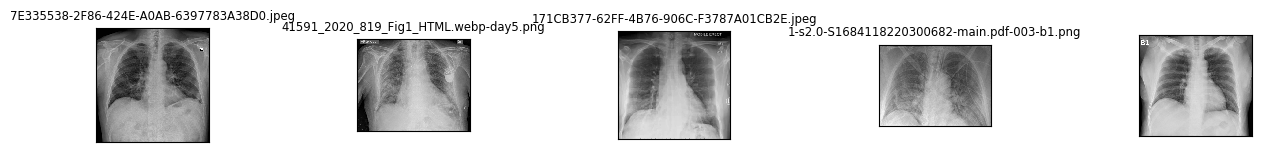


-------------------------------------------------------Normal-------------------------------------------------------


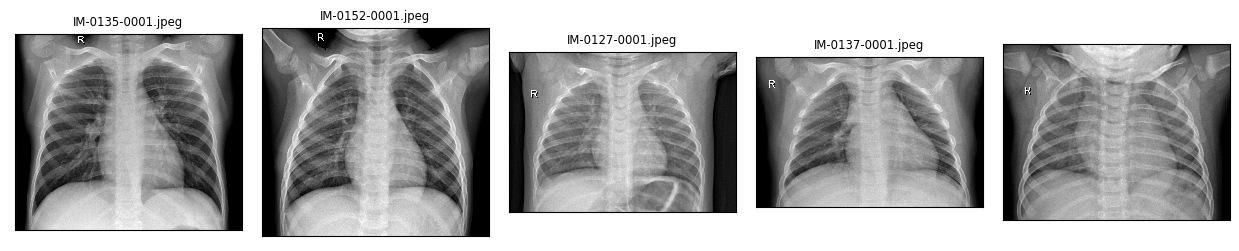


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [258]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

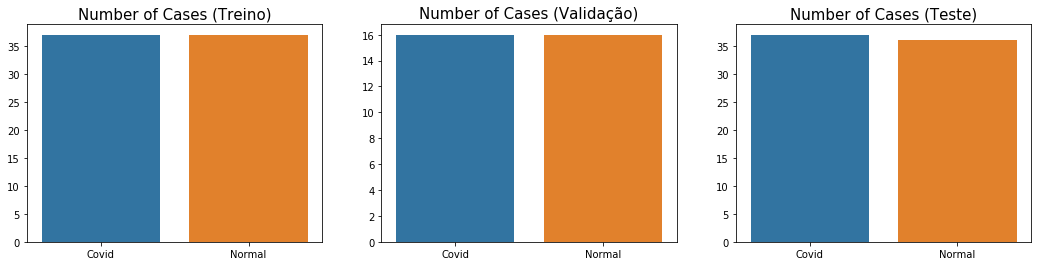

In [293]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 15
plot_params['label_fontsize'] = 13

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]



# Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and  Dataset 

In [260]:
rescale = 1./255
target_size = (150, 150)
batch_size = 64
class_mode = "categorical"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [261]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

#  Training Files Configuration

In [262]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1., 1.])

In [263]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_accuracy-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"

# Callbacks 

In [264]:
reset_graph()
reset_callbacks()

In [265]:
print("Settting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ", date_time(1))

Settting Callbacks at  Timestamp: 2020-03-20 02:18:26
Set Callbacks at  Timestamp: 2020-03-20 02:18:26


In [266]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150, 3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(150,150, 3)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2 , activation='softmax'))

    print(model.summary())
    
    return model

In [267]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
    x = AveragePooling2D(pool_size=(4, 4))(x)
    x = Flatten(name="flatten")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(headModel)
    x = Dense(2, activation="softmax")(x)

    
#     x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)
    
#     x = Dense(512, activation='relu')(x)
#     # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
#     model = Model(inputs=base_model.input, outputs=predictions)
    model = Model(inputs=base_model.input, outputs=x)

    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

# Training/Fine-Tuning Base Model-InceptionV3 for Fine-Tuning with New Class Labels

In [268]:
print("Getting Base Model", date_time(1))
# model = get_model()
model = get_conv_model()
# model = keras.models.load_model("data/output/models/2019-06-19 11-35-23/08-val_acc-0.94-val_loss-0.29.hdf5")

Getting Base Model Timestamp: 2020-03-20 02:18:26
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv

In [270]:
print("Starting Trainning Model", date_time(1))

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
optimizer= Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

# A compilacao serve para validar e finalizar a estrutura de nossa rede neural. Ela recebe 3 parametros:
# optimizer: 
# 1 - Função que define como os pesos da rede neural são atualizados. RMSProp é o mais utilizado em Keras, 
# porém esteja livre para experimentar com outros algoritmos e decidir qual é o ideal para seu caso.
# 2 - loss: Função de calcula a diferença entre os dados de teste e os dados de validação. Para classificadores 
# binários, usaremos a “binary_crossentropy”.
# 3- metrics: métricas que devem ser guardadas para avaliação.
model.compile(optimizer, loss=loss, metrics=metrics)

# Necessitamos escolher um numero de épocas de treino para nossa rede. 
# Se escolhermos um numero muito baixo de épocas, nosso algoritmo não 
# convirjará para um mínimo global. Se escolhermos um numero muito grande, 
# correremos o risco de nosso algoritmo se acostumar demais aos dados de 
# teste, e terá má performance em dados reais
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time(1))


Starting Trainning Model Timestamp: 2020-03-20 02:34:08
Epoch 1/100
2/2 [==============================] - 15s 7s/step - loss: 0.7440 - accuracy: 0.5833 - val_loss: 0.6757 - val_accuracy: 0.9667
Epoch 2/100
2/2 [==============================] - 13s 6s/step - loss: 0.6896 - accuracy: 0.6250 - val_loss: 0.6860 - val_accuracy: 0.5333
Epoch 3/100
2/2 [==============================] - 13s 6s/step - loss: 0.6814 - accuracy: 0.6250 - val_loss: 0.6833 - val_accuracy: 0.7333
Epoch 4/100
2/2 [==============================] - 13s 6s/step - loss: 0.6769 - accuracy: 0.5972 - val_loss: 0.6742 - val_accuracy: 0.9333
Epoch 5/100
2/2 [==============================] - 14s 7s/step - loss: 0.6657 - accuracy: 0.6389 - val_loss: 0.6451 - val_accuracy: 0.8667
Epoch 6/100
2/2 [==============================] - 13s 7s/step - loss: 0.6659 - accuracy: 0.5972 - val_loss: 0.6166 - val_accuracy: 0.6000
Epoch 7/100
2/2 [==============================] - 13s 6s/step - loss: 0.7308 - accuracy: 0.5278 - val_loss: 0

# Model Performance Visualization over the Epochs

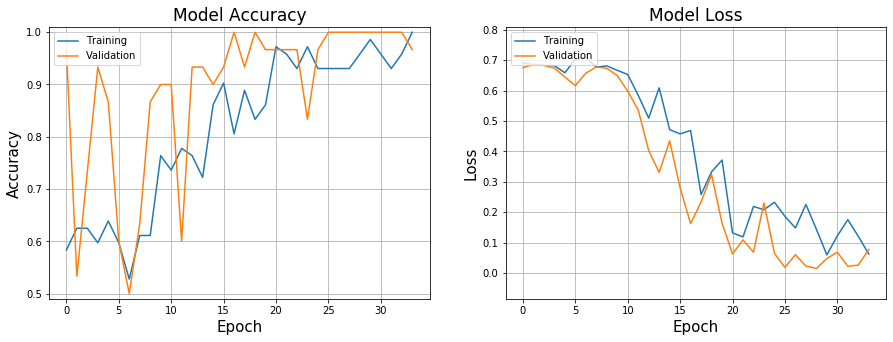

In [271]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
plt.show()

# Testing Saved Models

### Listing Local Models

In [273]:
dir_name = r"data/output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2020-03-20 01-08-32
1 2020-03-20 01-35-01
2 2020-03-20 01-38-46
3 2020-03-20 02-18-25


In [275]:
cur_dir =dir_name+dirs[3]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 01-val_accuracy-0.50-val_loss-0.69.hdf5
1 04-val_accuracy-0.57-val_loss-0.69.hdf5
2 05-val_accuracy-0.60-val_loss-0.69.hdf5
3 06-val_accuracy-0.73-val_loss-0.69.hdf5
4 07-val_accuracy-0.77-val_loss-0.69.hdf5
5 08-val_accuracy-0.80-val_loss-0.69.hdf5
6 09-val_accuracy-0.83-val_loss-0.69.hdf5
7 10-val_accuracy-0.90-val_loss-0.69.hdf5
8 11-val_accuracy-1.00-val_loss-0.69.hdf5


In [276]:
model_file = cur_dir+model_names[8]

print(model_file)

data/output/models/2020-03-20 02-18-25/11-val_accuracy-1.00-val_loss-0.69.hdf5


## Load local model

In [277]:
model = keras.models.load_model(model_file)

# Results

### Accuracy and Loss

In [278]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 13s 13s/step
Loss     : 0.69  
Accuracy : 83.33%


In [279]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 12s 12s/step


### Confusion Matrix

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 85.29%
Recall        : 80.56%
F1-Score      : 82.86%
------------------------------------------------------------------------------------------





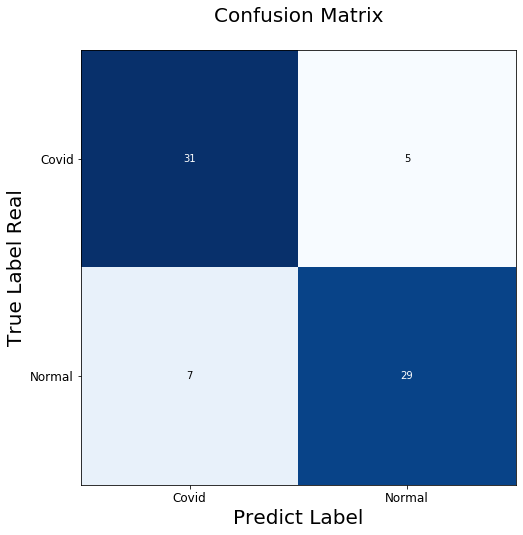

Accuracy: 83.33%
Sensitivity: 86.11%
Specificity: 80.56%



------------------------------------------------------------------------------------------
Report for Model File:  2020-03-20 02-18-25/11-val_accuracy-1.00-val_loss-0.69.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Covid       0.82      0.86      0.84        36
      Normal       0.85      0.81      0.83        36

    accuracy                           0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83      0.83        72

------------------------------------------------------------------------------------------


In [290]:
image_file_name_CM = figure_directory+"/CM"

title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel('True Label Real',fontsize=20)
plt.xlabel('Predict Label',fontsize=20)
fig.savefig(image_file_name_CM, dpi=100)
fig.savefig(figure_directory+"/CM.pdf", bbox_inches='tight')
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)


total1=sum(sum(CM))

##### From confusion matrix calculate accuracy
print("======================================")
accuracy1=(CM[0,0]+CM[1,1])/total1
print("%s%.2f%s"% ("Accuracy: ", accuracy1*100, "%"))

sensitivity1 = CM[0,0]/(CM[0,0]+CM[0,1])
print("%s%.2f%s"% ("Sensitivity: ", sensitivity1*100, "%"))

specificity1 = CM[1,1]/(CM[1,0]+CM[1,1])
print("%s%.2f%s"% ("Specificity: ", specificity1*100, "%"))


print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [281]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)


y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 72
-----------------------------------
Accuracy                : 83.33%
-----------------------------------


### ROC Curve


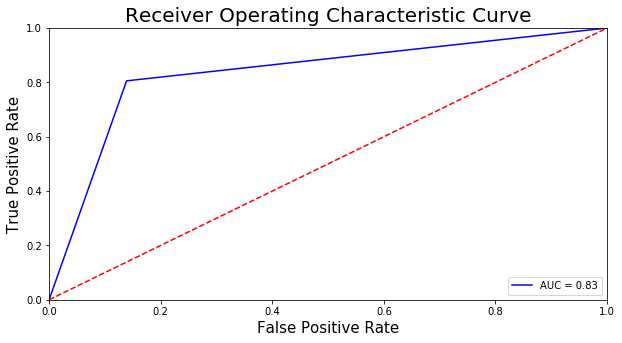

In [282]:
import sklearn.metrics as metrics

image_file_name_ROC = figure_directory+"/ROC"

fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Creating roc Object to R analysis
rocObj=[y_true, y_pred]
np.savetxt("results/inference/rocObj.csv", np.transpose(rocObj), header="y_true,y_pred", delimiter=",",fmt='%f', comments='')

roc_plot = plt.figure(figsize=(10, 5))
plt.title('Receiver Operating Characteristic Curve',fontsize=20)
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.show()
roc_plot.savefig(image_file_name_ROC, dpi=100)
roc_plot.savefig(figure_directory+"/ROC_curve.pdf", bbox_inches='tight')

# Estatistical Analysis

### Boostraping ROC Curve

In [283]:
import numpy as np
from scipy.stats import sem
from random import randint
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 10000
rng_seed = 1212  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
    
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

np.savetxt("results/inference/bootstrapped_scores.csv", bootstrapped_scores, delimiter=",",fmt='%f')


Original ROC area: 0.8333


### Histogram of the bootstrapped ROC AUC scores

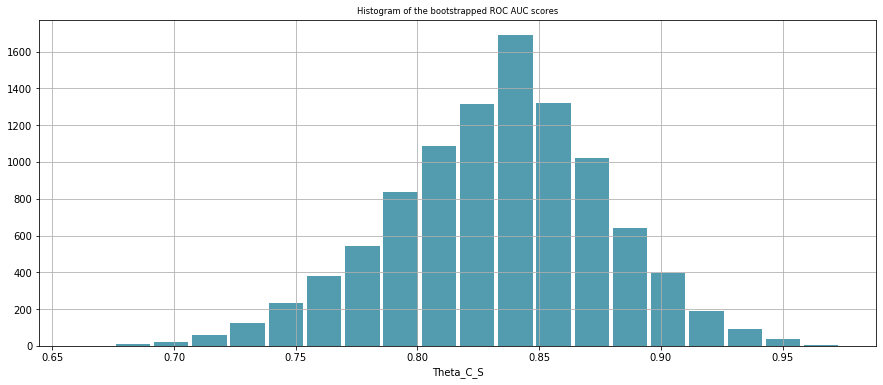

In [291]:
plot = plt.figure(figsize=(15, 6))
plt.hist(bootstrapped_scores, bins=20, rwidth=0.9,
                   color='#539caf')
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.xlabel('Theta_C_S')
plt.grid(True)
plt.show()
plot.savefig("results/inference/boostrapped_ROC_AUC_scores.pdf", bbox_inches='tight')

### Confidence Intervals

In [285]:
import statistics

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

print("Standart Deviation: {:0.3f}".format(statistics.stdev(sorted_scores)))
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Standart Deviation: 0.044
Confidence interval for the score: [0.744 - 0.916]


# Final Visualizations

### Visualization
**OBS**: Be carefull with slashes. They change according your operate system.

In [286]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            shutil.rmtree(image_file_name)

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()



### Visualization

In [287]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

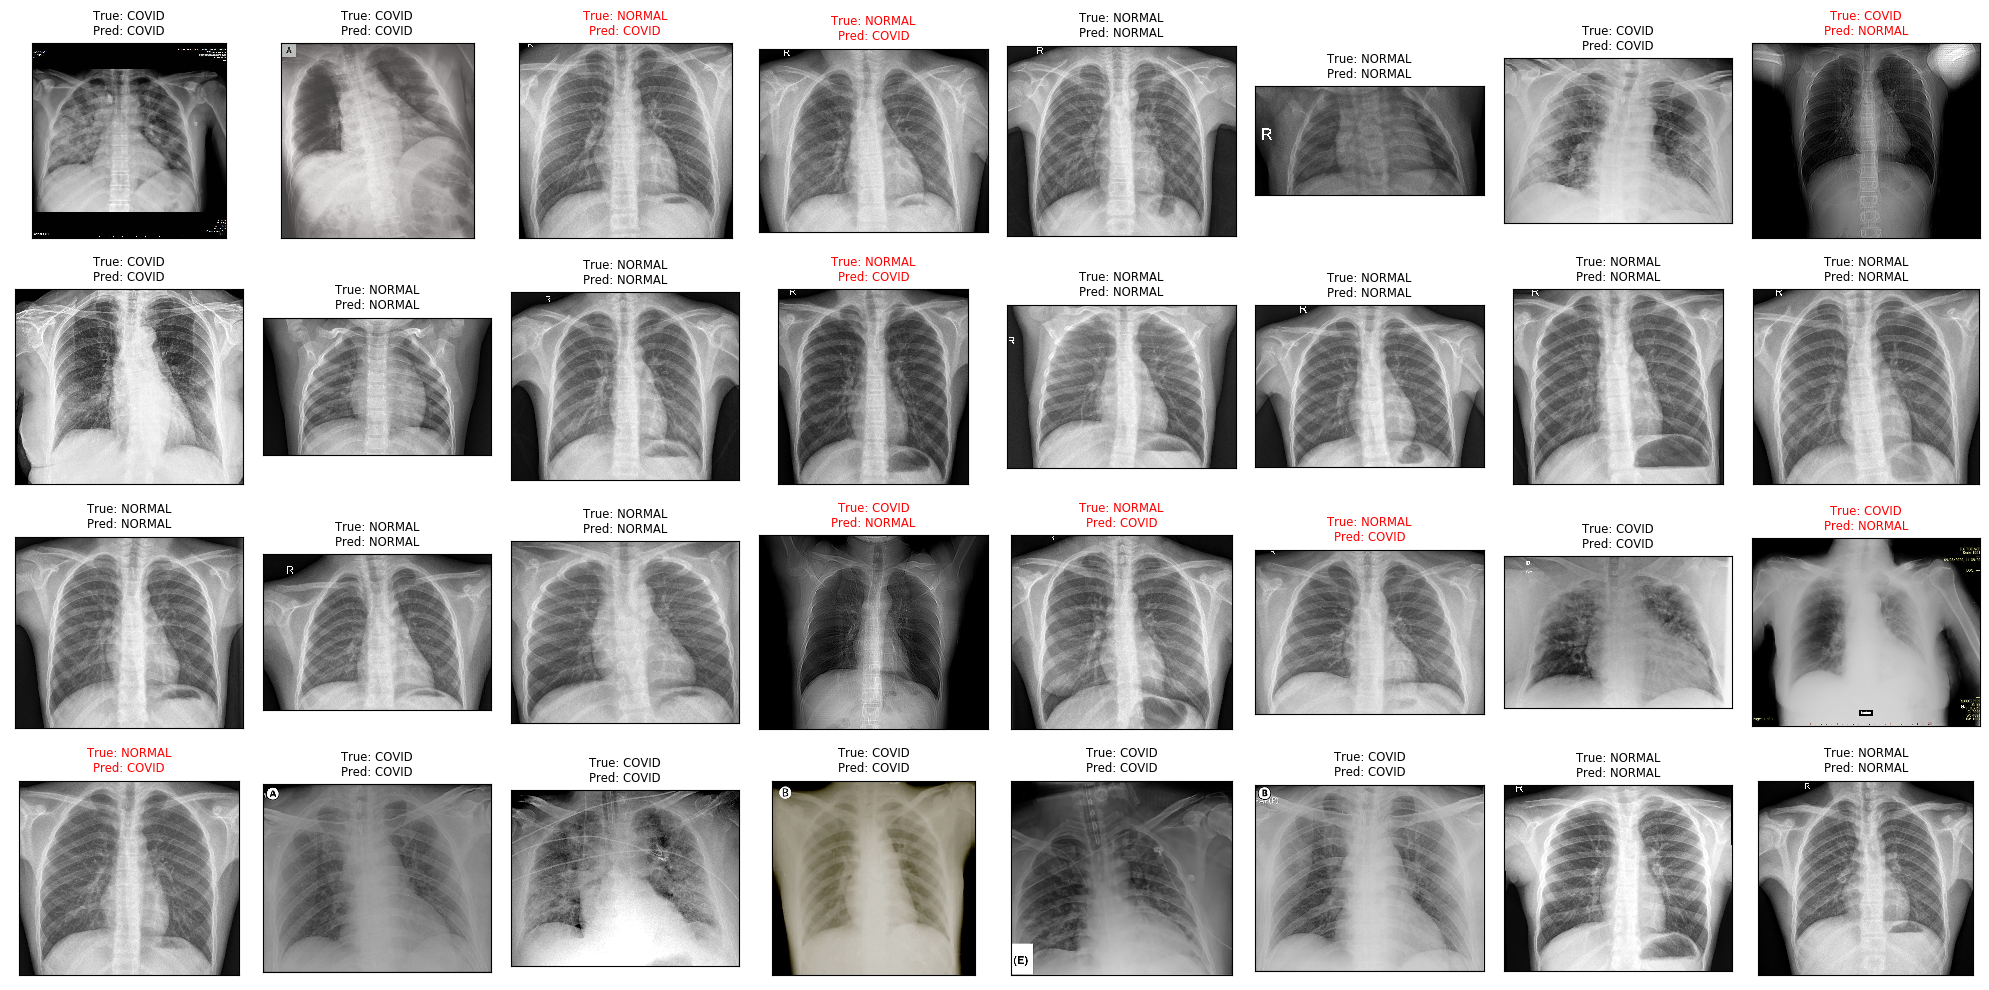

In [288]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

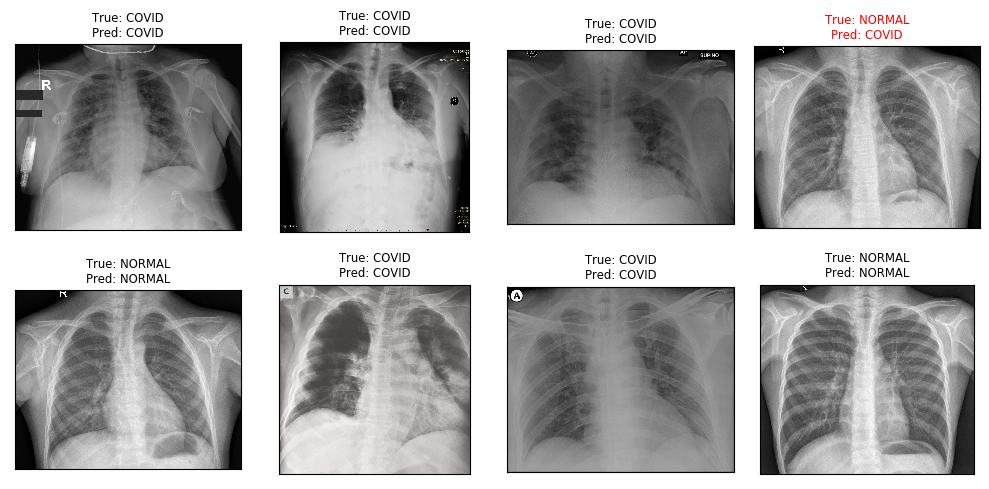

In [289]:
ncols = 4
nrows = 2

if batch_size_t<4:
    cols = 1
    
count = ncols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)